In [ ]:
###############
# That's the code that we used to build the model (no need to run it from scratch)
# Note that the model we saved only works when we are using a GPU

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense

Import and Download Data from Yahoo Finance

In [ ]:
import yfinance as yf

# Define the stock symbol
symbol = 'AAPL'  # Example: Apple Inc.

# Fetch historical data
df = yf.download(symbol, start="2016-01-01", end="2024-08-01")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Drop missing values
df.dropna(inplace=True)

# Drop negative values (assuming you want to remove rows with negative values in any column)
df = df[~(df < 0).any(axis=1)]

# Drop duplicated rows
df.drop_duplicates(inplace=True)


In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,25.652500,26.342501,25.500000,26.337500,23.886835,270597600
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.288248,223164000
2016-01-06,25.139999,25.592501,24.967501,25.174999,22.832500,273829600
2016-01-07,24.670000,25.032499,24.107500,24.112499,21.868862,324377600
2016-01-08,24.637501,24.777500,24.190001,24.240000,21.984503,283192000


Description of the columns:
- Open: This is the starting price for the stock on a given trading day and is used to analyze how the price moved throughout the day.
- High: This value helps in understanding the peak price level reached within the day. It is useful for assessing volatility and potential resistance levels.
- Low: This indicates the minimum price level reached during the day and is important for understanding support levels and volatility.
- Close: This is the final price of the stock for the trading day and is often used to calculate performance metrics and technical indicators.
- Adj Close: This adjusted figure provides a more accurate representation of the stock's value over time by accounting for changes in the number of shares or payouts to shareholders. It is useful for historical performance analysis and accurate returns calculation.
- Volume: his metric indicates the level of activity or liquidity of the stock. High volume can suggest strong investor interest and potentially higher volatility, while low volume might indicate less interest and lower liquidity.


Long-Short Term Memory (LSTM) for Time-Series Forecasting

In [ ]:
df = df.iloc[:, 3]
train_size = int(len(df) * 0.7)

train_data = df[:train_size]
test_data= df[train_size:]

In [ ]:
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_data_scaled = scaler.transform(test_data.values.reshape(-1, 1))

In [ ]:
seq_length = 120
series = df

X_train, Y_train = [], []
X_test, Y_test = [], []
for i in range(len(train_data) - seq_length):
    seq = train_data_scaled[i:i + seq_length]
    label = train_data_scaled[i + seq_length]
    X_train.append(seq)
    Y_train.append(label)

for i in range(len(test_data) - seq_length):
    seq = test_data_scaled[i:i + seq_length]
    label = test_data_scaled[i + seq_length]
    X_test.append(seq)
    Y_test.append(label)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

1D CNN and LSTM Network

In [ ]:
# # Define the model
#### Trying for 120 days forecasting model (4 months)

model = Sequential()

# Add a 1D Convolutional Layer
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(256, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.2))
model.add(Dense(1))

# Compile the model
optimizer = Adam(
    learning_rate=0.00001,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-07,
    amsgrad=False
)

optimizer2 = SGD(
    learning_rate=0.001,
    momentum=0.9,
    nesterov=True,
)

model.compile(optimizer=optimizer, loss= 'mean_squared_error')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, Y_train, epochs=75, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss = model.evaluate(X_test, Y_test)
print(f'Test Loss: {loss}')

Epoch 1/75
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0555 - val_loss: 0.4272
Epoch 2/75
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0441 - val_loss: 0.3343
Epoch 3/75
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0304 - val_loss: 0.2502
Epoch 4/75
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0206 - val_loss: 0.1608
Epoch 5/75
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0136 - val_loss: 0.0850
Epoch 6/75
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061 - val_loss: 0.0309
Epoch 7/75
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - val_loss: 0.0161
Epoch 8/75
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - val_loss: 0.0138
Epoch 9/75
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - val_loss: 0.0132
Epoch 10/75
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - val_loss: 0.0147
Epoch 11/75
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - val_loss: 0.0110
Epoch 12/75
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - val_l

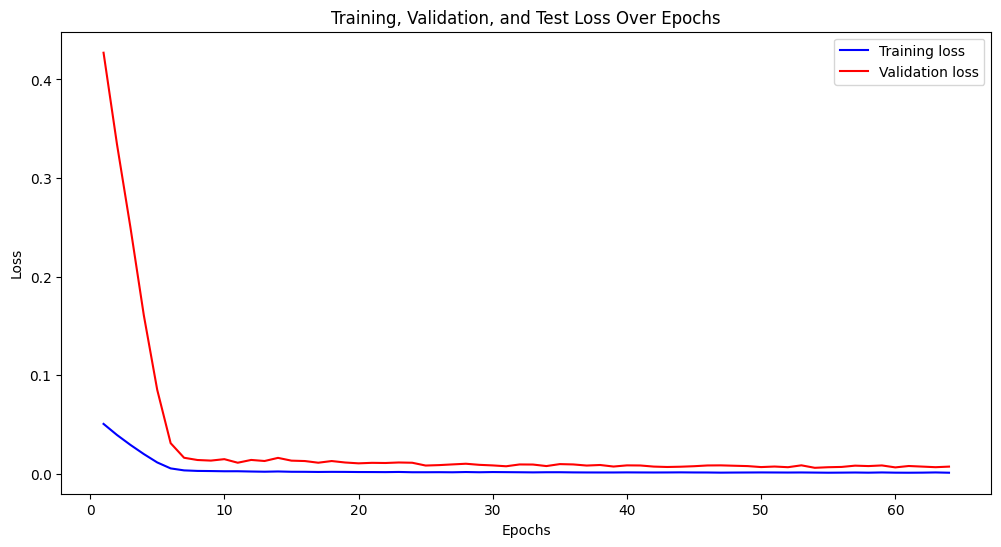

In [ ]:
import matplotlib.pyplot as plt

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
# test_loss = test_loss_callback.test_losses
epochs = range(1, len(train_loss) + 1)

# Plot training, validation, and test loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.plot(epochs, test_loss, 'g', label='Test loss')
plt.title('Training, Validation, and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Root Mean Squared Error: 18.44252001266141


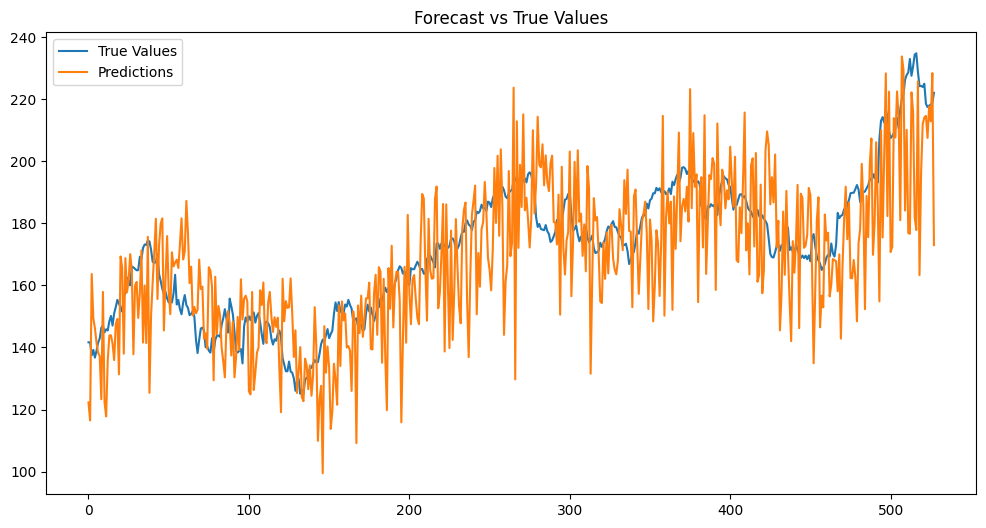

In [ ]:
# Test the Model
predictions = model.predict(X_test)

# Inverse transform to original scale

predictions = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(Y_test)


# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - y_test_inverse) ** 2))
print(f'Root Mean Squared Error: {rmse}')


# You may want to plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='True Values')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.title('Forecast vs True Values')
plt.show()

In [ ]:
model.save('CNN_LSTM_120_days.h5')

[*********************100%%**********************]  1 of 1 completed


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Root Mean Squared Error: 6.608643696264874


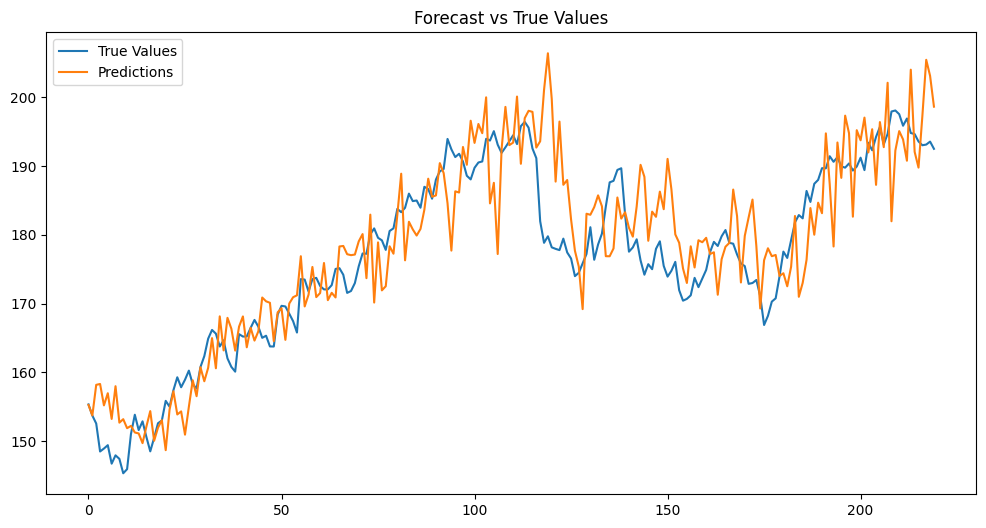

In [ ]:
############# Function to test our model on different dataset
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from tensorflow.keras.models import load_model

def get_data(symbol, start_date, end_date):
    df = yf.download(symbol, start_date, end_date)
    return df

def forecasting(df):

    data = df.iloc[:, 3]

    # Normalize the data

    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))
    seq_length = 30


    X, Y = [], []

    for i in range(len(data) - seq_length):
        seq = data_scaled[i: i + seq_length]
        label = data_scaled[i + seq_length]
        X.append(seq)
        Y.append(label)

    X = np.array(X)
    Y = np.array(Y)

    model = load_model('CNN_LSTM_120_days.h5')

    y_pred = model.predict(X)

    # Inverse transform to original scale
    y_pred = scaler.inverse_transform(y_pred)
    y = scaler.inverse_transform(Y.reshape(-1, 1))

    # Calculate RMSE
    rmse = np.sqrt(np.mean((y_pred - y) ** 2))
    print(f'Root Mean Squared Error: {rmse}')


    # You may want to plot the results

    plt.figure(figsize=(12, 6))
    plt.plot(y, label='True Values')
    plt.plot(y_pred, label='Predictions')
    plt.legend()
    plt.title('Forecast vs True Values')
    plt.show()

# Example usage
symbol = 'AAPL'
start_date = '2023-01-01'
end_date = '2024-01-01'
df = get_data(symbol, start_date, end_date)
forecasting(df)


[*********************100%%**********************]  1 of 1 completed


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Root Mean Squared Error: 13.10795146835912


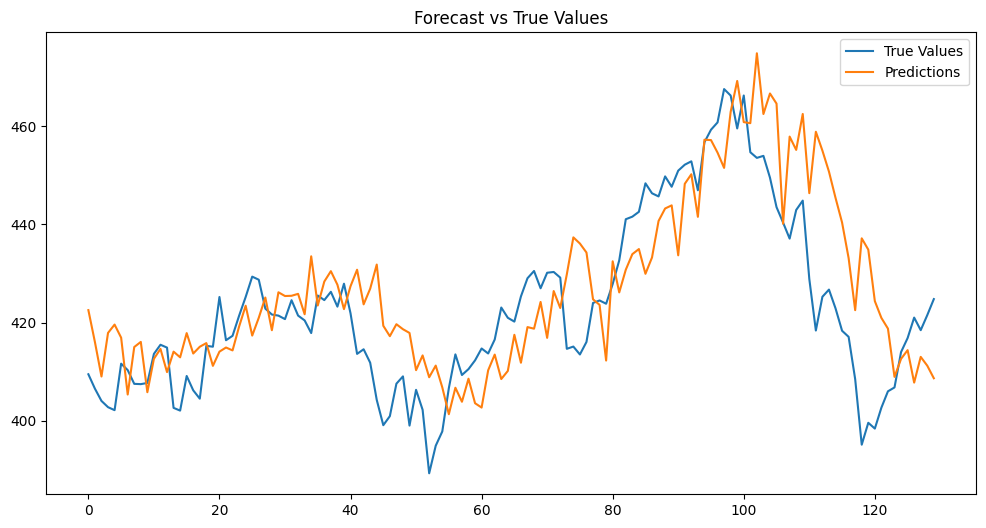

In [ ]:
df = get_data('MSFT', '2024-01-01', '2024-12-01')

forecasting(df)

Forcast the next 2 month prices, and evaluate if it is accurate

[*********************100%%**********************]  1 of 1 completed


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step
Root Mean Squared Error: 11.473505761317925
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━

[*********************100%%**********************]  1 of 1 completed


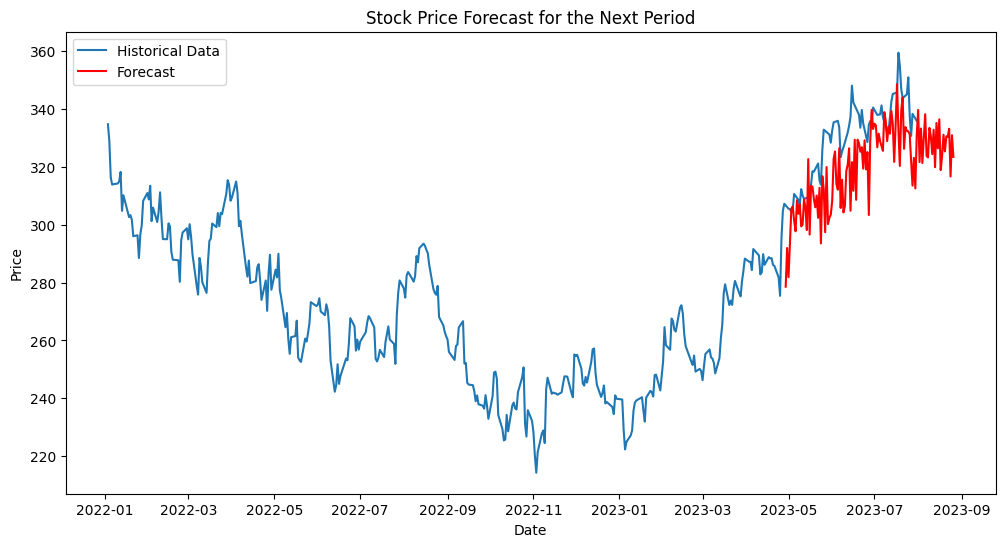

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from tensorflow.keras.models import load_model

def get_data(symbol, start_date, end_date):
    df = yf.download(symbol, start_date, end_date)
    return df

def forecasting(df, days_to_forecast=120):
    data = df[['Close']]

    # Normalize the data
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))
    seq_length = 100

    X, Y = [], []

    for i in range(len(data) - seq_length):
        seq = data_scaled[i: i + seq_length]
        label = data_scaled[i + seq_length]
        X.append(seq)
        Y.append(label)

    X = np.array(X)
    Y = np.array(Y)

    model = load_model('CNN_LSTM_120_days.h5')

    # Predict on the historical data
    y_pred = model.predict(X)

    # Inverse transform to original scale
    y_pred = scaler.inverse_transform(y_pred)
    y = scaler.inverse_transform(Y.reshape(-1, 1))

    # Calculate RMSE
    rmse = np.sqrt(np.mean((y_pred - y) ** 2))
    print(f'Root Mean Squared Error: {rmse}')

    # # Plot historical predictions
    # plt.figure(figsize=(12, 6))
    # plt.plot(y, label='True Values')
    # plt.plot(y_pred, label='Predictions')
    # plt.legend()
    # plt.title('Historical Forecast vs True Values')
    # plt.show()

    # Forecasting the next period
    def forecast_next_period(model, data, seq_length, n_forecasts, scaler):
        forecasts = []
        last_sequence = data[-seq_length:]

        for _ in range(n_forecasts):
            last_sequence_scaled = scaler.transform(last_sequence.reshape(-1, 1)).reshape(1, seq_length, 1)
            forecast_scaled = model.predict(last_sequence_scaled)
            forecast = scaler.inverse_transform(forecast_scaled)[0, 0]
            forecasts.append(forecast)
            last_sequence = np.append(last_sequence[1:], forecast)

        return forecasts

    # Forecast the next period (e.g., 60 days)
    forecasts = forecast_next_period(model, data.values, seq_length, days_to_forecast, scaler)

    # Generate future dates
    future_dates = [df.index[-1] + timedelta(days=i) for i in range(1, days_to_forecast + 1)]

    symbol = 'MSFT'
    start_date = '2022-01-01'
    end_date = '2023-08-01'
    df_2 = get_data(symbol, start_date, end_date)

    # Plot historical data and forecast
    plt.figure(figsize=(12, 6))
    plt.plot(df_2.index, df_2.iloc[:, 3].values, label='Historical Data')
    plt.plot(future_dates, forecasts, label='Forecast', color='red')
    plt.legend()
    plt.title('Stock Price Forecast for the Next Period')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

    return forecasts, future_dates

# Example usage
symbol = 'MSFT'
start_date = '2022-01-01'
end_date = '2023-05-01'
df = get_data(symbol, start_date, end_date)
forecasts, future_dates = forecasting(df)



[*********************100%%**********************]  1 of 1 completed


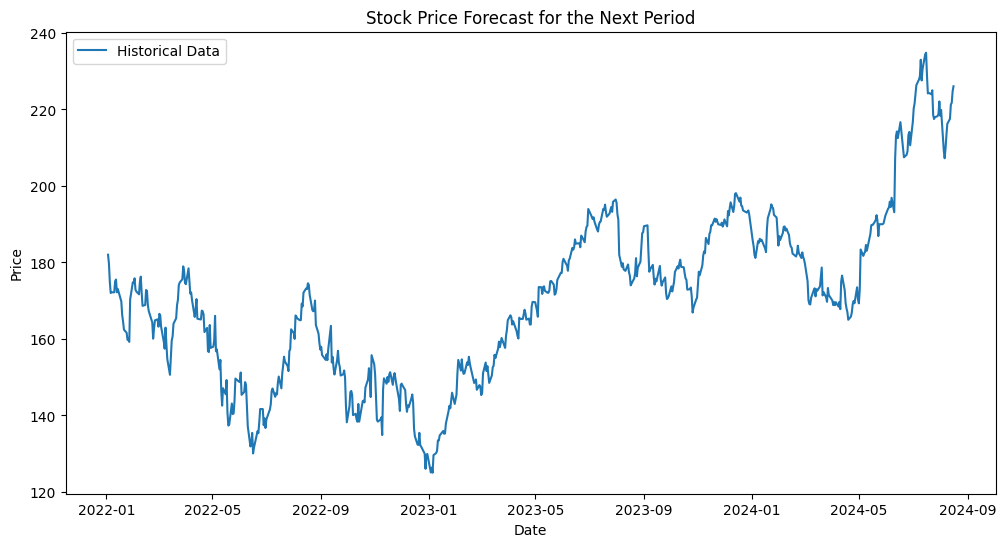

In [ ]:
# Example usage
symbol = 'AAPL'
start_date = '2022-01-01'
end_date = '2024-11-01'
df_2 = get_data(symbol, start_date, end_date)

# Plot historical data and forecast
plt.figure(figsize=(12, 6))
plt.plot(df_2.index, df_2.iloc[:,3].values, label='Historical Data')
plt.legend()
plt.title('Stock Price Forecast for the Next Period')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()